# Прогнозирование количества заказов такси  

**Описание исследования**  

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Цель исследования**
- Создать модель, которая будет предсказывать количество заказов в следующий час
- Метрика RMSE модели должна быть не больше 48

**Ход исследования**
- Разведочный анализ данных
- Предобработка данных при необходимости
- Создание выборок
- Построение пайплайнов
- Обучение моделей
- Проверка константной моделью
- Общий вывод

## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn import set_config

set_config(display="diagram")

import re

from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
try:
    df = pd.read_csv(
        r"C:\workspace\yandex_cources\full_history\sprint_11_time_series\data\taxi.csv",
        parse_dates=["datetime"],
        index_col=["datetime"],
    )
except:
    df = pd.read_csv(
        r"/datasets/taxi.csv", parse_dates=["datetime"], index_col=["datetime"]
    )

Заранее сделаем копию чистого датасета

In [3]:
df_copy = df.copy()

## Определение функций

In [4]:
def data_understanding(df):
    print("\n" * 2, "=" * 26, "5 случайных строк датасета", "=" * 27, "\n" * 2)
    display(df.sample(5))
    print("\n", "=" * 31, "Размеры датасета", "=" * 32, "\n" * 2)
    display(df.shape)
    print("\n" * 2, "=" * 29, "Информация о датасетe", "=" * 29, "\n" * 2)
    df.info()
    print(
        "\n" * 2, "=" * 21, "Информация о количественных признаках", "=" * 21, "\n" * 2
    )
    display(df.describe())

In [5]:
def boxplot_builder(df, column, coef1, coef2):
    plt.figure(figsize=(7, 3))
    plt.boxplot(
        x=df[column],
        notch=True,
        vert=False,
        patch_artist=True,
    )
    plt.title(f"{column} boxplot")
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    left_border = Q1 - 1.5 * IQR
    right_border = Q3 + 1.5 * IQR
    plt.xlim(left_border * coef1, right_border * coef2)

In [6]:
def make_time_features(df):
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["day_of_week"] = df.index.dayofweek
    df["hour"] = df.index.hour

In [7]:
def make_arima_features(df, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        df["lag_{}".format(lag)] = df["num_orders"].shift(lag)

    for size in rolling_mean_size:
        df["rolling_mean_{}".format(size)] = (
            df["num_orders"].shift().rolling(size).mean()
        )

In [8]:
def kpss_test(timeseries):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return kpss_output

In [9]:
def rmse_resid(y_test, preds):
    print("=" * 79, "\n")
    print(f"RMSE = {mean_squared_error(y_test, preds, squared=False):.4f}\n")

    (y_test - preds).plot(figsize=(10, 2))
    plt.title("Residual")
    plt.xlabel("Datetime")
    print(f"Resid median: {(y_test - preds).median():.3f}\n")
    print("=" * 79, "\n")

In [10]:
def rmse_resid_tune(y_test, preds):
    preds_tuned = preds + (y_test - preds).median()

    print("=" * 79, "\n")
    print(f"RMSE = {mean_squared_error(y_test, preds_tuned, squared=False):.4f}\n")

    (y_test - preds).plot(figsize=(10, 2))
    plt.title("Residual")
    plt.xlabel("Datetime")
    print(f"Resid median: {(y_test - preds_tuned).median():.3f}\n")
    print("=" * 79, "\n")
    return preds_tuned

In [11]:
def target_vs_preds(y_trest, preds, name):
    y_test.resample("1D").sum().plot(
        label="Target",
        legend=True,
        linestyle=(0, (4, 0, 4, 3)),
        linewidth=1.2,
        figsize=(6, 4),
    )
    pd.Series(preds, index=y_test.index).resample("1D").sum().plot(
        label="Predictions", legend=True, linestyle=(0, (8, 3, 2, 3)), linewidth=1.2
    )
    plt.title(f"Target vs Predictions {name}")
    plt.ylabel("Orders")
    plt.xlabel("Date")

## Разведочный анализ данных

In [12]:
data_understanding(df)



 ========================== 5 случайных строк датасета =========================== 




,num_orders
datetime,
2018-07-04 13:40:00,12
2018-08-29 16:00:00,42
2018-05-29 12:40:00,18
2018-03-26 13:50:00,6
2018-07-10 13:10:00,14



 =============================== Размеры датасета ================================ 




(26496, 1)



 ============================= Информация о датасетe ============================= 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


 ===================== Информация о количественных признаках ===================== 




,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Разложим индексы на новые признаки

In [13]:
make_time_features(df)

In [14]:
df.sample()

,num_orders,month,day,day_of_week,hour
datetime,,,,,
2018-07-22 10:00:00,11,7,22,6,10


Декомпозируем данные и посмотрим на наличие тренда и сезонности.

In [15]:
df_decomposed = seasonal_decompose(df.num_orders.resample("1D").sum())

Text(0.5, 0, 'Month')

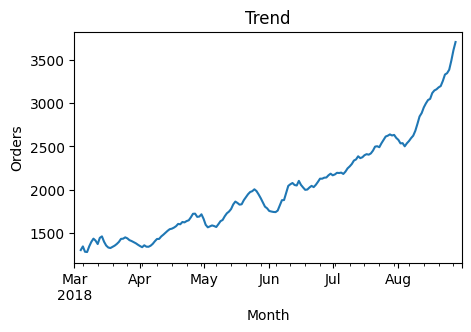

In [16]:
df_decomposed.trend.plot(ax=plt.gca(), figsize=(5, 3))
plt.title("Trend")
plt.ylabel("Orders")
plt.xlabel("Month")

Явно виден тренд, что говорит нам о нестационарности ряда. 

In [17]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

ts = df["num_orders"]
st_test = adfuller(ts, regression="ctt")

print(
    "Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный"
)
if st_test[1] < 0.05:
    print("Наш ряд стационарный")
else:
    print("Ряд нестационарный")

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


Text(0.5, 0, 'Month')

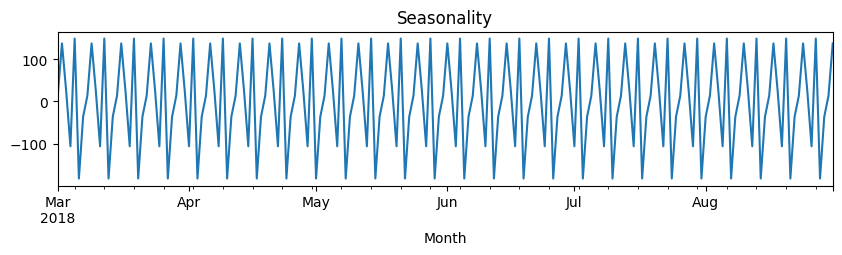

In [18]:
df_decomposed.seasonal.plot(ax=plt.gca(), figsize=(10, 2))
plt.title("Seasonality")
plt.xlabel("Month")

Text(0.5, 0, 'Date')

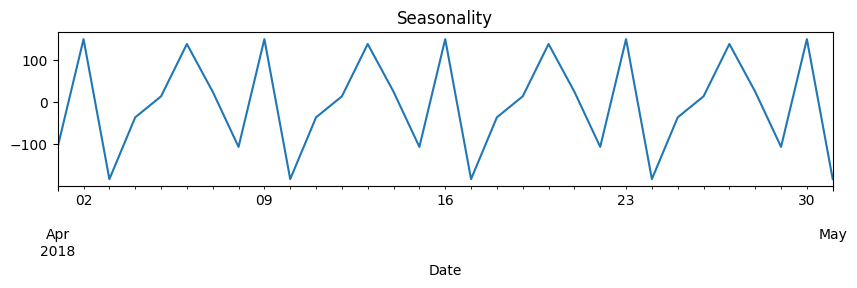

In [19]:
df_decomposed.seasonal["2018-04-01":"2018-05-01"].plot(ax=plt.gca(), figsize=(10, 2))
plt.title("Seasonality")
plt.xlabel("Date")

In [20]:
df_decomposed.seasonal["2018-04-01":"2018-05-01"].index.dayofweek

Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
       2, 3, 4, 5, 6, 0, 1],
      dtype='int32', name='datetime')

Присутствует двойная недельная сезонность: количество заказов имеет пик в ночь с воскресенья на понедельник и в пятницу, а также вечером вторника и субботы, что указывает на нестационарность. 

Посмотрим на строки, где число заказов равно 0.

Text(0, 0.5, 'Count')

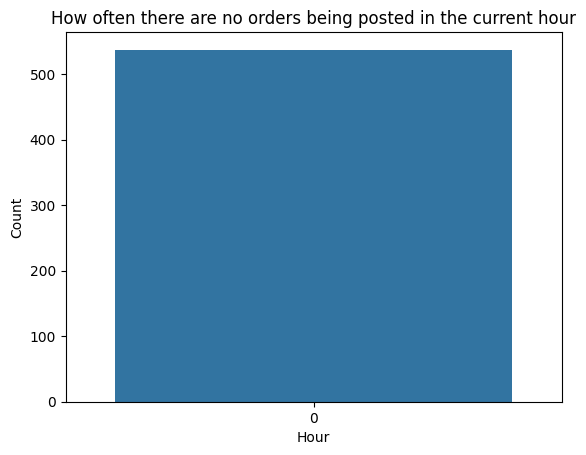

In [21]:
sns.countplot(df[df.num_orders == 0]["hour"])
plt.title("How often there are no orders being posted in the current hour")
plt.xlabel("Hour")
plt.ylabel("Count")

Похоже что чаще всего нулевое число заказов соответствует промежутку 5-7 часов утра. Неожиданно, но допустимо.   
Заметно, что несколько значений времени отсуствуют, проверим, существует ли полный набор в полном датасете.

In [22]:
df.hour.sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

Все хорошо. 

Посмотрим, как число заказов распределено по часам и дням недели.

Text(0, 0.5, 'Num of orders')

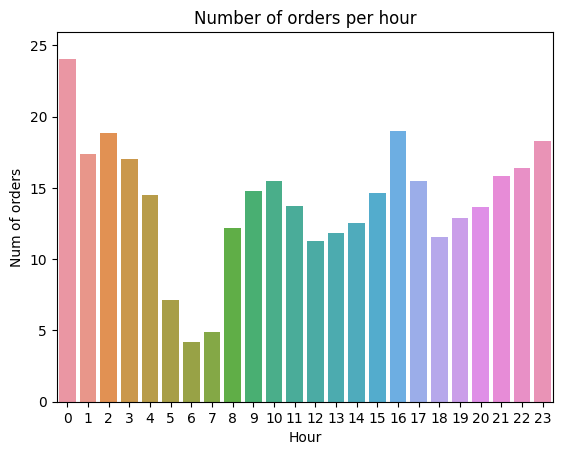

In [23]:
sns.barplot(data=df, x="hour", y="num_orders", errwidth=0)
plt.title("Number of orders per hour")
plt.xlabel("Hour")
plt.ylabel("Num of orders")

Text(0, 0.5, 'Num of orders')

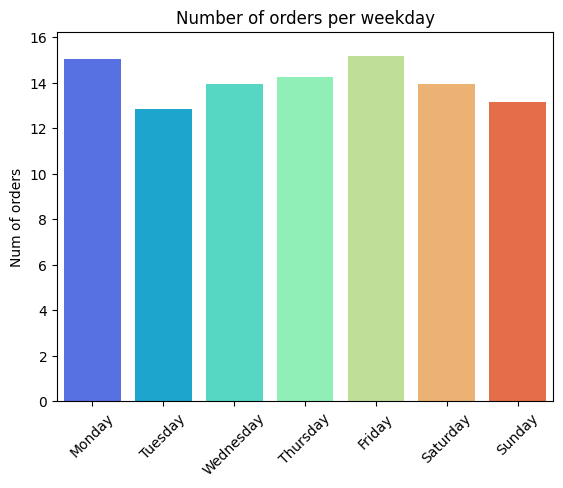

In [24]:
sns.barplot(data=df, x="day_of_week", y="num_orders", errwidth=0, palette="rainbow")
plt.title("Number of orders per weekday")
bars = ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
plt.xticks(np.arange(len(bars)), bars, rotation=45)
plt.xlabel("")
plt.ylabel("Num of orders")

Особой разницы в числе заказов между днями недели нет, зато есть явная зависимость от времени дня: в 0 часов число заказов максимально, к 6 утра оно падает до минимума, а в 4 часа дня имеет отдельный пик. 

Посмотрим на ежедневное распределение заказов через временной ряд.

In [25]:
day = df.num_orders["2018-04-01 00:00":"2018-04-09 00:00"]
day_decomposed = seasonal_decompose(day.resample("1H").sum())

Text(0.5, 0, 'Day')

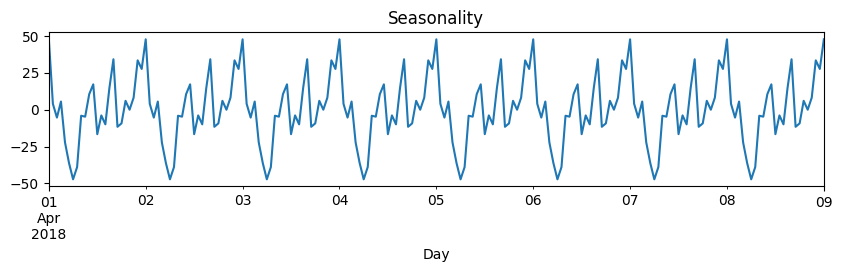

In [26]:
day_decomposed.seasonal.plot(ax=plt.gca(), figsize=(10, 2))
plt.title("Seasonality")
plt.xlabel("Day")

Text(0.5, 0, 'Hour')

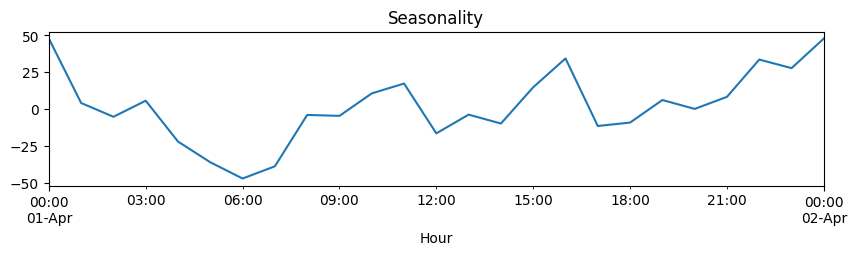

In [27]:
day_decomposed.seasonal["2018-04-01 00:00":"2018-04-02 00:00"].plot(
    ax=plt.gca(), figsize=(10, 2)
)
plt.title("Seasonality")
plt.xlabel("Hour")

На примере недели 2.04 - 9.04 видна сильная ежедневная сезонность, что также указывает на нестационарность. 

Посмотрим, как менялось среднее число заказов в день в течение исследуемого периода.

Text(0.5, 1.0, 'Average number of calls per day')

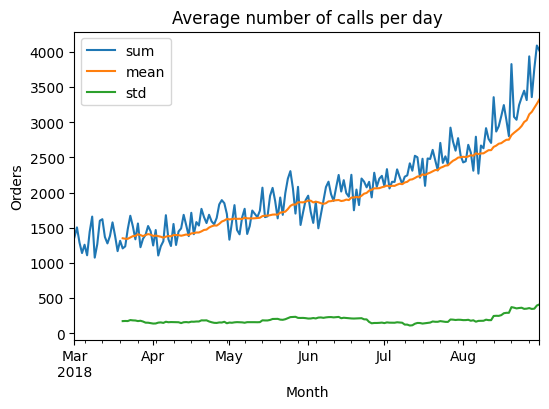

In [28]:
df.num_orders.resample("1D").sum().plot(label="sum", legend=True, figsize=(6, 4))
df.num_orders.resample("1D").sum().rolling(20).mean().plot(label="mean", legend=True)
df.num_orders.resample("1D").sum().rolling(20).std().plot(label="std", legend=True)
plt.ylabel("Orders")
plt.xlabel("Month")
plt.title("Average number of calls per day")

Рост среднего в очередной раз подтверждает нестационарность временного ряда. 

Проведем тест Дики-Фуллера, чтобы обедиться наверняка: 
- Нулевая гипотеза: распределение нестационарное, зависящее от времени;
- Альтернативная гипотеза: распределение стационарное, не зависящее от времени.

In [29]:
stationary_test = adfuller(df.num_orders)

In [30]:
print(f"\np-value: {stationary_test[1]}")
if stationary_test[1] < 0.05:
    print("\nОтвергаем нулевую гипотезу: ряд стационарный.\n\n")
else:
    print("\nНулевая гипотеза принимается: ряд нестационарный.\n\n")


p-value: 2.2286378815481225e-23

Отвергаем нулевую гипотезу: ряд стационарный.




Тест Дики-Фуллера опровергает предположение, что процесс нестационарен.  

Проведем тест КПСС. В нем:
- Нулевая гипотеза: распределение стационарное;
- Альтернативная гипотеза: распределение нестационарное. 

In [31]:
print(f"\np-value: {kpss_test(df.num_orders)[1]}")
if kpss_test(df.num_orders)[1] < 0.05:
    print("\nОтвергаем нулевую гипотезу: ряд нестационарный.\n\n")
else:
    print("\nНулевая гипотеза принимается: ряд стационарный.\n\n")


p-value: 0.01

Отвергаем нулевую гипотезу: ряд нестационарный.




C:\Users\ivand\AppData\Local\Temp\ipykernel_3148\3671935194.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
C:\Users\ivand\AppData\Local\Temp\ipykernel_3148\3671935194.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Тест КПСС наоборот, утверждает что ряд нестационарен.

Построим график автокорреляции ряда, ресемплированного по одному часу, с числом лагов 336, что соответствует продолжительности двух недели. 

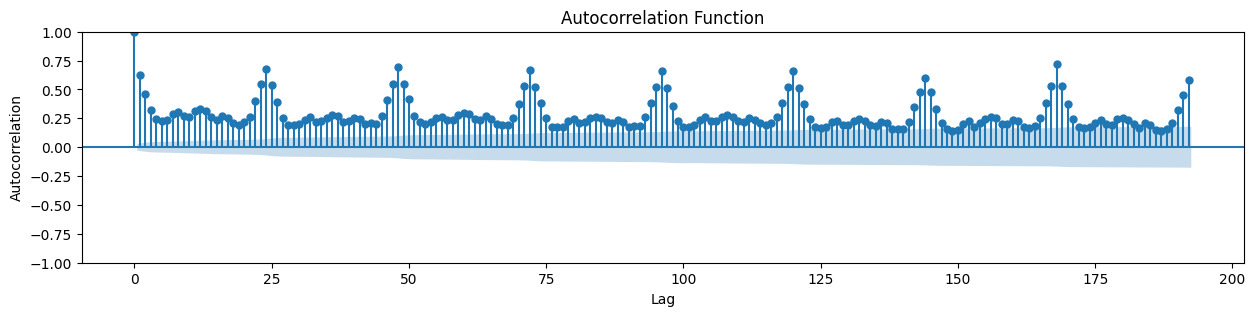

In [32]:
figure, ax = plt.subplots(figsize=(15, 3))

plot_acf(ax=ax, x=df.resample("1H").sum().num_orders, lags=192)

plt.title("Autocorrelation Function")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

График автокорреляции в очередной раз доказывает, что ряд нестационарен. 

Поскольку исследуемый ряд является нестационарным, необходмо создание признаков, которые позволят модели найти точки соприкосновения с трендом и сезонностью. 

## Создание пайплайнов

OneHotEncoder позволит разбить столбец `day_of_week` на признаки, по которым модель сможет отслеживать сезонность. 

In [33]:
ohe = ColumnTransformer(
    [("ohe", OneHotEncoder(sparse=False, drop="first"), ["day_of_week"])],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [34]:
lr_pipe = Pipeline(
    [("ohe", ohe), ("std", StandardScaler()), ("lr", LinearRegression())]
)

In [35]:
en_pipe = Pipeline([("ohe", ohe), ("std", StandardScaler()), ("en", ElasticNet())])

## Создание выборок

Поскольку нам необходимо предсказание на 1 час, необходимо ресемплировать датасет. С добавленными ранее временными признаками это сделать затруднительно, поэтому на основе копии датасета пересоберем набор данных.

In [36]:
df_sampling = df_copy.copy()

In [37]:
df_sampling = df_sampling.resample("1H").sum()

Добавим лаги, скользящее среднее (можно сказать, частично выполним пайплайн аримы) и некоторые сезонные особенности в качестве признаков для остальных моделей и разобъем на выборки. 

In [38]:
make_time_features(df_sampling)

In [39]:
# (dataframe, n_lags, rolling_mean_size list)
make_arima_features(df_sampling, 72, [4, 6, 8, 14, 28])
df_sampling = df_sampling.dropna()

In [40]:
df_sampling.loc[(df_sampling.index.hour.isin([5, 6, 7])), "is_morning"] = 1
df_sampling.loc[~(df_sampling.index.hour.isin([5, 6, 7])), "is_morning"] = 0

In [41]:
df_sampling.loc[(df_sampling.index.hour.isin([16])), "is_evening"] = 1
df_sampling.loc[~(df_sampling.index.hour.isin([16])), "is_evening"] = 0

In [42]:
df_sampling.loc[(df_sampling.index.hour.isin([0])), "is_night"] = 1
df_sampling.loc[~(df_sampling.index.hour.isin([0])), "is_night"] = 0

In [43]:
X = df_sampling.drop(columns="num_orders")

In [44]:
y = df_sampling.num_orders

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [46]:
X_train.sample()

,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_71,lag_72,rolling_mean_4,rolling_mean_6,rolling_mean_8,rolling_mean_14,rolling_mean_28,is_morning,is_evening,is_night
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-15 12:00:00,7,15,6,12,62.0,61.0,92.0,73.0,36.0,48.0,...,80.0,126.0,72.0,62.0,67.75,85.928571,91.214286,0.0,0.0,0.0


## Обучение моделей

In [47]:
tscv = TimeSeriesSplit(n_splits=5)

### Linear Regression

In [48]:
lr_params = {}

In [49]:
lr_md = GridSearchCV(
    lr_pipe,
    lr_params,
    scoring="neg_root_mean_squared_error",
    n_jobs=1,
    cv=2,
    error_score="raise",
)

In [50]:
lr_md.fit(X_train, y_train)

c:\workspace\yandex_cources\full_history\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\workspace\yandex_cources\full_history\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\workspace\yandex_cources\full_history\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=2, error_score='raise',
             estimator=Pipeline(steps=[('ohe',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['day_of_week'])],
                                                          verbose_feature_names_out=False)),
                                       ('std', StandardScaler()),
                                       ('lr', LinearRegression())]),
             n_jobs=1, param_grid={}, scoring='neg_root_mean_squared_error')

In [51]:
abs(lr_md.best_score_)

24.397979650245915

### ElasticNet

In [52]:
en_params = {
    "en__alpha": np.arange(0.1, 2, 0.05),
    "en__l1_ratio": np.arange(0.2, 0.8, 0.05),
    "en__random_state": [42],
}

In [53]:
en_md = GridSearchCV(
    en_pipe,
    en_params,
    scoring="neg_root_mean_squared_error",
    n_jobs=4,
    cv=tscv,
    error_score="raise",
)

In [54]:
en_md.fit(X_train, y_train)

c:\workspace\yandex_cources\full_history\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('ohe',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['day_of_week'])],
                                                          verbose_feature_names_out=False)),
                                       ('std', StandardScaler()),
                                       ('en', ElasticNet())]),
             n_jobs=4,
             param_grid={'en__alpha': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 ,
       1.75, 1.8 , 1.85, 1.9 , 1.95]),
                         'en__l1_ratio': array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 ]),
                         'en__random_state': [42]},
             scoring='neg_root_mean_squared_error')

In [55]:
abs(en_md.best_score_)

23.046154851471663

In [56]:
abs(en_md.best_score_)

23.046154851471663

## Испытание на тестовой выборке

In [57]:
en_preds = en_md.predict(X_test)

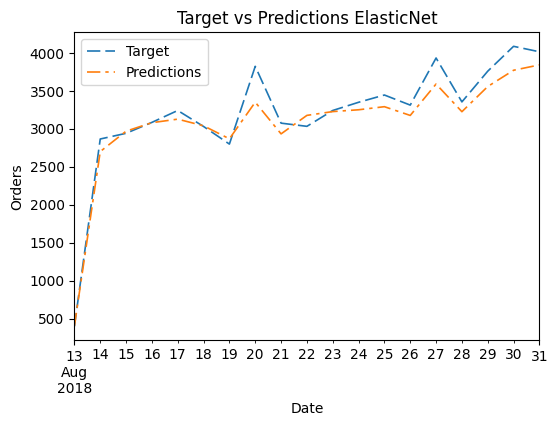

In [58]:
target_vs_preds(y_test, en_preds, "ElasticNet")


RMSE = 40.2410

Resid median: 1.186




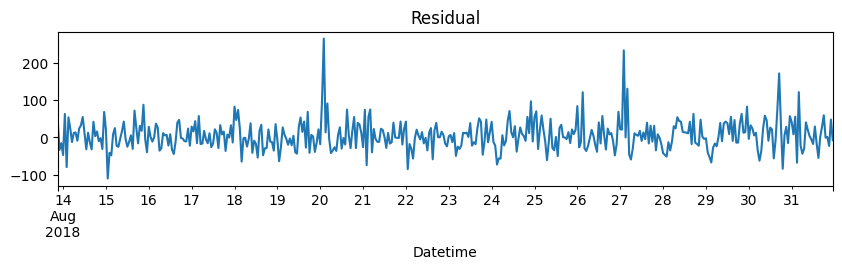

In [59]:
rmse_resid(y_test, en_preds)

## Испытание константной моделью

In [60]:
dummy_preds = y_test.shift()
dummy_preds.iloc[0] = y_train.iloc[-1]

In [61]:
print("=" * 79, "\n")
print(f"bestRMSE = {mean_squared_error(y_test, en_preds, squared=False):.4f}\n")
print(f"constRMSE = {mean_squared_error(y_test, dummy_preds, squared=False):.4f}\n")
if mean_squared_error(y_test, en_preds, squared=False) < mean_squared_error(
    y_test, dummy_preds, squared=False
):
    print(f"Проверка на вменяемость пройдена\n")
    print("=" * 79)
else:
    print(f"Проверка на вменяемость не пройдена\n", "=" * 79)
    print("=" * 79)


bestRMSE = 40.2410

constRMSE = 59.1497

Проверка на вменяемость пройдена



## Общий вывод

**В ходе выполнения исследования** был рассмотрен датасет, содержащий исторические данные о заказах такси в аэропортах, при помощи которого были обучены модели, предсказывающие спрос на такси в следующий час.

**Выполнены следующие этапы:**  
- **Разведочных анализ данных**  
    Изучено содержимое датасета, временной ряд проанализирован на тренд и сезонность;  
- **Создание выборок**  
    Датасет разделен на тренировочные и тестовые выборки, подходящие испытываемым моделям; 
- **Построение пайплайнов**  
    Созданы пайплайны для моделей LinearRegressiom, ElasticNet, RandomForestRegressor;
- **Обучение моделей**  
    Подобраны оптимальные гипер-параметры модели ElasticNet при помощи GridSearchCV, произведена оценка предсказаний, получаемых моделями. ElasticNet показывает лучшие результаты по сравнению с простой LinearRegression. 

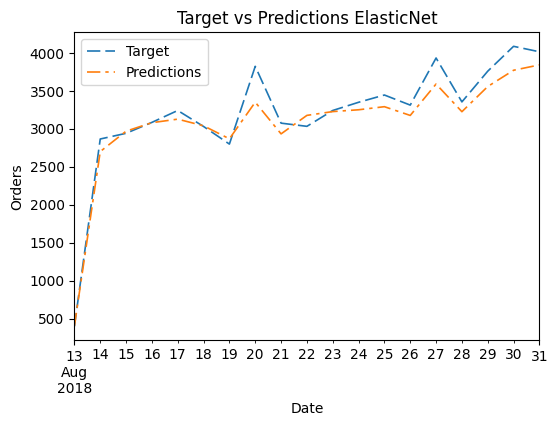

In [62]:
target_vs_preds(y_test, en_preds, "ElasticNet")

- **Проверека константной моделью**  
    Проверка константной моделью успешно пройдена.

In [63]:
print("=" * 79, "\n")
print(f"bestRMSE = {mean_squared_error(y_test, en_preds, squared=False):.4f}\n")
print(f"constRMSE = {mean_squared_error(y_test, dummy_preds, squared=False):.4f}\n")
print("=" * 79)


bestRMSE = 40.2410

constRMSE = 59.1497

